In [5]:
!ls Logs

0  1  2  3  4  5  6  7	8  9


# Resultados

## Parseo

In [8]:
import pandas as pd
from pathlib import Path
import numpy as np
from collections import defaultdict

BASE_DIR = Path("./Logs")

# config_name -> lista de best_runs
results = defaultdict(list)

for run_dir in BASE_DIR.iterdir():
    if not run_dir.is_dir():
        continue

    for csv_file in run_dir.glob("*.csv"):
        config_name = csv_file.stem  # nombre de la configuración (sin .csv)

        df = pd.read_csv(csv_file)

        if "min_fitness" not in df.columns:
            raise ValueError(f"{csv_file} no tiene la columna 'min_fitness'")

        best_run = df["min_fitness"].min()
        results[config_name].append(best_run)

# construir DataFrame final
rows = []

for config, best_runs in results.items():
    if len(best_runs) < 2:
        print(f"[WARN] {config} solo tiene {len(best_runs)} ejecuciones")

    rows.append({
        "config": config,
        "mean": np.mean(best_runs),
        "std": np.std(best_runs, ddof=1),
        "best": np.min(best_runs)
    })

In [10]:
summary_df = pd.DataFrame(rows)

if summary_df.empty:
    raise RuntimeError("No se ha cargado ninguna configuración")

summary_df = summary_df.sort_values("best").reset_index(drop=True)
summary_df.head(5)

,config,mean,std,best
0,CodGrupo_TSP_random_0.7_True_0.1_pmx_6,8.340805,0.317365,7.750374
1,CodGrupo_TSP_random_0.8_True_0.1_pmx_8,8.217800,0.257114,7.780497
2,CodGrupo_TSP_random_0.8_True_0.1_ox_2,8.210724,0.224508,7.782077
3,CodGrupo_TSP_random_0.8_True_0.1_pmx_10,8.456536,0.345912,7.784127
4,CodGrupo_TSP_inversion_0.8_True_0.1_ox_12,8.187350,0.206441,7.828979


In [12]:
def parse_config(config_name: str) -> dict:
    """
    Parsea nombres tipo:
    CodGrupo_TSP_random_0.7_True_0.1_pmx_6
    """
    # eliminar prefijo fijo
    clean = config_name.replace("CodGrupo_TSP_", "")

    parts = clean.split("_")

    if len(parts) != 6:
        raise ValueError(f"Formato inesperado en config: {config_name}")

    mutation = parts[0]
    pcross = float(parts[1])
    elitism = parts[2] == "True"
    pmut = float(parts[3])
    crossover = parts[4]
    T = int(parts[5])

    return {
        "mutation": mutation,
        "pcross": pcross,
        "elitism": elitism,
        "pmut": pmut,
        "crossover": crossover,
        "T": T
    }


In [13]:
params_df = summary_df["config"].apply(parse_config).apply(pd.Series)

final_df = pd.concat(
    [summary_df.drop(columns="config"), params_df],
    axis=1
)

final_df

,mean,std,best,mutation,pcross,elitism,pmut,crossover,T
0,8.340805,0.317365,7.750374,random,0.7,True,0.10,pmx,6
1,8.217800,0.257114,7.780497,random,0.8,True,0.10,pmx,8
2,8.210724,0.224508,7.782077,random,0.8,True,0.10,ox,2
3,8.456536,0.345912,7.784127,random,0.8,True,0.10,pmx,10
4,8.187350,0.206441,7.828979,inversion,0.8,True,0.10,ox,12
...,...,...,...,...,...,...,...,...,...
187,24.648900,1.107653,22.464236,scramble,0.7,True,0.01,pmx,8
188,23.938275,0.968800,22.686273,scramble,0.7,True,0.01,pmx,2
189,24.339077,1.070716,22.902940,scramble,0.7,True,0.01,pmx,10
190,25.050230,1.194481,23.792737,scramble,0.7,True,0.01,pmx,12


In [15]:
final_df.to_csv("TSP_summary.csv")

## Estudio

In [27]:
# !pip install seaborn

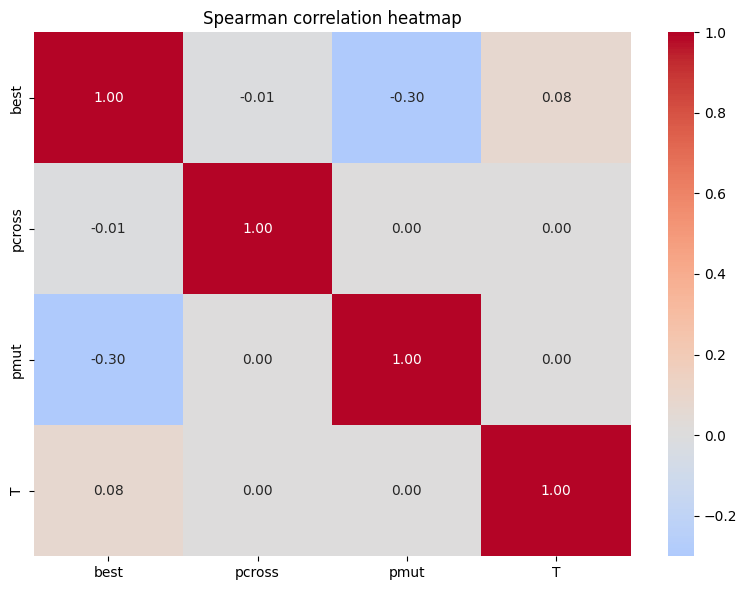

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = final_df[
    ["best", "pcross", "pmut", "T"]
].corr(method="spearman")

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f"
)
plt.title("Spearman correlation heatmap")
plt.tight_layout()
plt.show()

El análisis de correlación muestra que la tasa de mutación (pmut) es el parámetro con mayor influencia sobre la calidad final de la solución, presentando una correlación negativa moderada con el valor óptimo. Dado que el objetivo del problema es la minimización, esta relación indica que incrementar la probabilidad de mutación tiende a producir soluciones de mejor calidad, favoreciendo la exploración del espacio de búsqueda y reduciendo el riesgo de convergencia prematura.

Por otro lado, la probabilidad de cruce (pcross) no evidencia una influencia apreciable sobre el rendimiento, lo que sugiere que su efecto depende de interacciones con otros parámetros o del operador de cruce empleado. El tamaño poblacional (T) muestra un impacto marginal dentro del rango evaluado, indicando que incrementarlo no aporta mejoras significativas en la calidad de las soluciones.

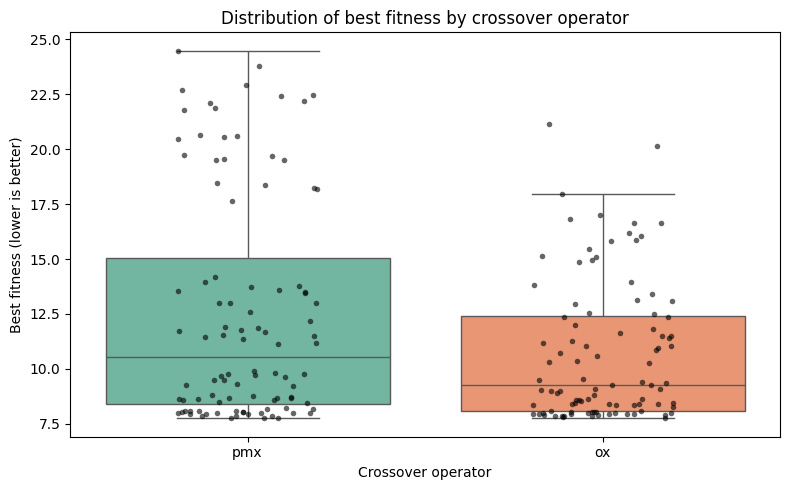

In [30]:
plt.figure(figsize=(8, 5))

sns.boxplot(
    data=final_df,
    x="crossover",
    y="best",
    hue="crossover",
    showfliers=False,
    palette="Set2",
    legend=False
)

sns.stripplot(
    data=final_df,
    x="crossover",
    y="best",
    color="black",
    alpha=0.6,
    jitter=0.2,
    size=4
)

plt.title("Distribution of best fitness by crossover operator")
plt.xlabel("Crossover operator")
plt.ylabel("Best fitness (lower is better)")
plt.tight_layout()
plt.show()

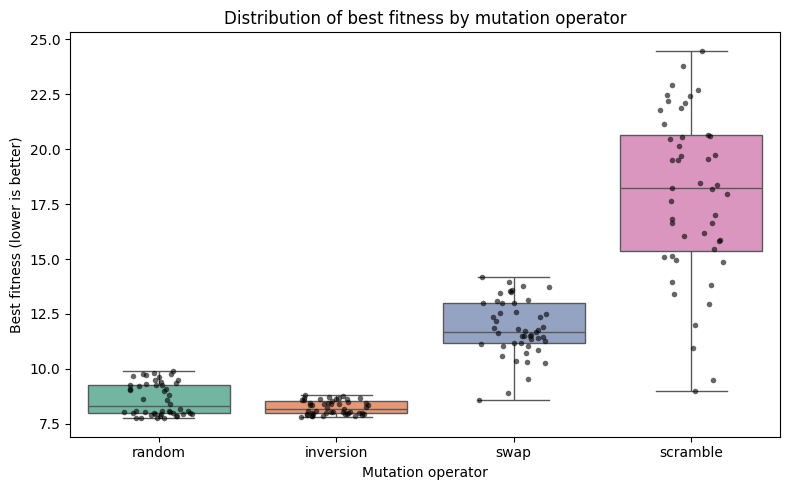

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

sns.boxplot(
    data=final_df,
    x="mutation",
    y="best",
    hue="mutation",
    showfliers=False,
    palette="Set2",
    legend=False
)

sns.stripplot(
    data=final_df,
    x="mutation",
    y="best",
    color="black",
    alpha=0.6,
    jitter=0.2,
    size=4
)

plt.title("Distribution of best fitness by mutation operator")
plt.xlabel("Mutation operator")
plt.ylabel("Best fitness (lower is better)")
plt.tight_layout()
plt.show()